# Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from MetabolomicsPaper.GeneralHelperFunctions import *
from sklearn.model_selection import RandomizedSearchCV

paper_dir = '/net/mraid08/export/jafar/Microbiome/Analyses/Noamba/Metabolon/Paper_v6/'
figure_dir = os.path.join(paper_dir, 'Figure3')
make_dir_if_not_exists(figure_dir)
os.chdir(paper_dir)

/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load data

In [2]:
grouped_metabs = pd.read_csv('../technical_noise/dataframes/mar17_metabolomics_grouped085_unnormed_fillna_min_dayfromfirstsample_regressed_rzs.csv', index_col=0)
single_metabs = pd.read_csv('../technical_noise/dataframes/mar17_metabolomics_unnormed_fillna_min_dayfromfirstsample_regressed_rzs.csv', index_col=0)
grouped_metabs_sp = pd.read_csv('../technical_noise/dataframes/mar17_metabolomics_grouped085_unnormed_fillna_min_dayfromfirstsample_regressed_metabs.csv', index_col=0).loc[grouped_metabs.columns]
grouped_metabs_sp = grouped_metabs_sp.replace({'Lipid':'Lipids', 'Nucleotide':'Nucleotides', 'Amino Acid':'Amino acids', 'Peptide':'Peptides', 
                                               'Xenobiotic':'Xenobiotics', 'Unknown':'Unknowns', 'Carbohydrate':'Carbohydrates'})

mar17_features = pd.read_csv('dataframes/mar17_features.csv', index_col=0)#.replace({'Gender':{'Male':1, 'Female':0}})
may18_features = pd.read_csv('dataframes/may18_features.csv', index_col=0).replace({'Gender':{'Male':1, 'Female':0}})
mar17_stool_info = pd.read_csv('dataframes/mar17_stool_info.csv', index_col=0)
may18_stool_info = pd.read_csv('dataframes/may18_stool_info.csv', index_col=0)
pnp_ids =  pd.read_csv('dataframes/pnp_ids.csv', index_col=0)
metabs1 = pd.read_csv('dataframes/metabs1.csv', index_col=0)
metabs_no_nan = metabs1.fillna('Unknown').copy()
metabs_no_nan = metabs_no_nan.replace({'Lipid':'Lipids', 'Nucleotide':'Nucleotides', 'Amino Acid':'Amino acids', 'Peptide':'Peptides', 
                                       'Xenobiotic':'Xenobiotics', 'Unknown':'Unknowns', 'Carbohydrate':'Carbohydrates'})

mb_full_abs_shap = pd.read_csv('/net/mraid08/export/jafar/Microbiome/Analyses/Noamba/Metabolon/technical_noise/RSCV/LightGBM/metabolomics_MB_daphna_LONG5_S/abs_shap.csv', index_col=0)
mb_full_results = pd.read_csv('/net/mraid08/export/jafar/Microbiome/Analyses/Noamba/Metabolon/technical_noise/RSCV/LightGBM/metabolomics_MB_daphna_LONG5_S/results.csv', index_col=0)
mb_full = pd.read_csv('dataframes/mar17_daphna_LONG5_s.csv', index_col=0)

diet_full_abs_shap = pd.read_csv('/net/mraid08/export/jafar/Microbiome/Analyses/Noamba/Metabolon/technical_noise/RSCV/LightGBM/metabolomics_ffq+diet0.05/abs_shap.csv', index_col=0)
diet_full_results = pd.read_csv('/net/mraid08/export/jafar/Microbiome/Analyses/Noamba/Metabolon/technical_noise/RSCV/LightGBM/metabolomics_ffq+diet0.05/results.csv', index_col=0)
diet_full = pd.read_csv('dataframes/mar17_ffq+diet0.05.csv', index_col=0)

# Colors

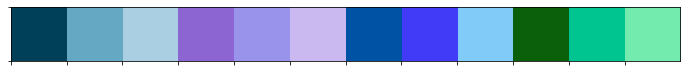

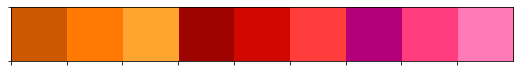

In [3]:
costume_colors_features = ['#004159', '#65A8C4', '#AACEE2', '#8C65D3', '#9A93EC', '#CAB9F1', '#0052A5', '#413BF7', '#81CBF8', '#0B610B', '#00C590', '#73EBAE']
costume_colors_metabs = ['#CC5800', '#FF7A05', '#FFA42E', '#9E0300', '#D10700', '#FF3D3D', '#B3007A', '#FF3D7E', '#FF7AB6']
sns.palplot(costume_colors_features)
# plt.savefig(os.path.join(figure_2_dir, 'colors_features.png'), dpi=50, bbox_inches='tight')
sns.palplot(costume_colors_metabs)
# plt.savefig(os.path.join(figure_2_dir, 'colors_metabs.png'), dpi=50, bbox_inches='tight')

super_pathway_color = {'Cofactors and Vitamins':costume_colors_metabs[0],'Peptides':costume_colors_metabs[1], 'Lipids':costume_colors_metabs[2],
                      'Amino acids':costume_colors_metabs[3], 'Energy':costume_colors_metabs[4], 'Xenobiotics':costume_colors_metabs[5],
                      'Carbohydrates':costume_colors_metabs[6], 'Nucleotides':costume_colors_metabs[7],'Unknowns':costume_colors_metabs[8]}

# Single bacteria $R^2$ vs full MB model $R^2$

Foreach metabolite, choose the bacterial feature with the highest mean absolute SHAP value and run a prediction model (LightGBM) using only this feature.

Plot the $R^2$ from the single model against the $R^2$ from the full microbiome model

In [4]:
PREDICTOR_PARAMS_DEFAULT = {'learning_rate': 0.01, 'max_depth': 5,
                            'feature_fraction': 1, 'num_leaves': 25,
                            'min_data_in_leaf': 15, 'metric': 'l2',
                            'early_stopping_rounds': None, 'n_estimators': 500,
                            'bagging_fraction': 0.8, 'bagging_freq': 1,
                            'num_threads': 1, 'verbose': -1, 'silent': True}

def pred_cv(X, Y, k_folds=5, model='lightgbm'):

    results_df = pd.DataFrame(index=Y.columns)
    predictions_df = pd.DataFrame(index=Y.index, columns=Y.columns)
    shap_values_dic = {}

    for y_name in Y.columns:

        y = Y[y_name].dropna().astype(float).copy()
        X_temp = X.loc[y.index].dropna(how='all').copy()
        y = y.loc[X_temp.index]

        if y.unique().shape[0] == 2:
            classification_problem = True
        else:
            classification_problem = False

        groups = np.array(range(X_temp.shape[0]))
        group_kfold = GroupKFold(n_splits=k_folds)
        shap_values = pd.DataFrame(np.nan, index=X_temp.index, columns=X_temp.columns)
        final_pred = pd.DataFrame(index=X_temp.index, columns=[y_name])

        for train_index, test_index in group_kfold.split(X_temp, y, groups):
            X_train, X_test = X_temp.iloc[train_index, :], X_temp.iloc[test_index, :]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            pred_model = _choose_model(model, classification_problem, PREDICTOR_PARAMS_DEFAULT)

            pred_model.fit(X_train, y_train)
            if classification_problem:
                y_pred = pred_model.predict_proba(X_test)
                final_pred.loc[X_test.index, :] = np.expand_dims(y_pred[:, 1], 1)
            else:
                y_pred = pred_model.predict(X_test)
                final_pred.loc[X_test.index, :] = np.expand_dims(y_pred, 1)

        results_df = _evaluate_performance(y_name, final_pred.values.ravel(), y, results_df, classification_problem)
        predictions_df.loc[final_pred.index, y_name] = final_pred.values.ravel()
    return results_df


def _choose_model(model, classification_problem, predictor_params):
    if model == 'lightgbm':
        if classification_problem:
            return lgb.LGBMClassifier(**predictor_params)
        else:
            return lgb.LGBMRegressor(**predictor_params)
    else:
        return None

def _evaluate_performance(y_name, y_pred, y_test, results_df, classification_problem):
    results_df.loc[y_name, 'Size'] = y_pred.shape[0]
    if classification_problem:
        # Prevalence
        results_df.loc[y_name, 'prevalence'] = float(y_test.sum()) / y_test.shape[0]
        # AUC
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
        results_df.loc[y_name, 'AUC'] = metrics.auc(fpr, tpr)
        # PR
        precision, recall, _ = precision_recall_curve(y_test, y_pred)
        results_df.loc[y_name, 'Precision_Recall'] = metrics.auc(recall, precision)
    else:
        results_df.loc[y_name, 'Coefficient_of_determination'] = r2_score(y_true=y_test, y_pred=y_pred)
        results_df.loc[y_name, 'explained_variance_score'] = explained_variance_score(y_true=y_test, y_pred=y_pred)
        results_df.loc[y_name, 'pearson_r'], results_df.loc[y_name, 'pearson_p'] = pearsonr(y_pred, y_test)
        results_df.loc[y_name, 'spearman_r'], results_df.loc[y_name, 'spearman_p'] = spearmanr(y_pred, y_test)
    return results_df

In [88]:
# res_list = []

# for m in tqdm_notebook(single_metabs.columns):
#     best_f = mb_full_abs_shap.loc[m].sort_values().tail(1).index.values[0]
#     res_list.append(pred_cv(mb_full[[best_f]], single_metabs[[m]]))

# mb_single_best_feature_res = pd.concat(res_list, sort=True)
# mb_single_best_feature_res.index.names = ['CHEMICAL_ID']
# mb_single_best_feature_res.to_csv(os.path.join(figure_dir, 'mb_single_best_feature_res.csv'))

/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#depre

/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#depre

/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#depre

/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#depre

/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#depre

/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#depre

/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#depre

/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#depre

/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#depre

/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#depre

/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#depre

/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#depre

/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#depre

/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#depre

/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#depre

/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#depre

/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#depre

/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#depre

/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#depre

/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#depre

/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#depre

/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#depre

/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#depre

/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#depre

/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#depre

/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#depre

/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#depre

/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#depre

/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#depre

/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#depre

/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#depre

/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#depre

/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#depre

/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#depre

/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#depre

/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#depre

/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#depre

/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#depre

/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#depre

/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#depre

/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#depre

/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#depre

/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#depre

/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#depre

/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#depre

/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#depre

/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#depre

/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#depre

/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#depre

In [309]:
# res_list = []

# for m in tqdm_notebook(single_metabs.columns):
#     best_f = diet_full_abs_shap.loc[m].sort_values().tail(1).index.values[0]
#     res_list.append(pred_cv(diet_full[[best_f]], single_metabs[[m]]))

# diet_single_best_feature_res = pd.concat(res_list, sort=True)
# diet_single_best_feature_res.index.names = ['CHEMICAL_ID']
# diet_single_best_feature_res.to_csv(os.path.join(figure_dir, 'diet_single_best_feature_res.csv'))

In [5]:
mb_single_best_feature_res = pd.read_csv( '../Paper_v2/Figure4/mb_single_best_feature_res.csv', index_col=0)
diet_single_best_feature_res = pd.read_csv('../Paper_v2/Figure4/diet_single_best_feature_res.csv', index_col=0)

# Plot

In [115]:
diet_pred = pd.read_csv('../technical_noise/RSCV/LightGBM/metabolomics_shap_ot0.05_ffq+diet0.05/predictions_df.csv', index_col=0)
diet_res = pd.read_csv('../technical_noise/RSCV/LightGBM/metabolomics_shap_ot0.05_ffq+diet0.05/results.csv', index_col=0)
diet_abs_shap = pd.read_csv('../technical_noise/RSCV/LightGBM/metabolomics_shap_ot0.05_ffq+diet0.05/abs_shap.csv', index_col=0)
diet_abs_signed_shap = pd.read_csv('../technical_noise/RSCV/LightGBM/metabolomics_shap_ot0.05_ffq+diet0.05/abs_signed_shap.csv', index_col=0)

mb_pred = pd.read_csv('../technical_noise/RSCV/LightGBM/metabolomics_shap_ot0.05_MB_daphna_LONG5_S//predictions_df.csv', index_col=0)
mb_res = pd.read_csv('../technical_noise/RSCV/LightGBM/metabolomics_shap_ot0.05_MB_daphna_LONG5_S/results.csv', index_col=0)
mb_abs_shap = pd.read_csv('../technical_noise/RSCV/LightGBM/metabolomics_shap_ot0.05_MB_daphna_LONG5_S/abs_shap.csv', index_col=0)
mb_abs_signed_shap = pd.read_csv('../technical_noise/RSCV/LightGBM/metabolomics_shap_ot0.05_MB_daphna_LONG5_S/abs_signed_shap.csv', index_col=0)

max_res = pd.concat((mb_res, diet_res), sort=True).reset_index().groupby('index').apply(lambda x: x.loc[x.Coefficient_of_determination.idxmax()])
abs_shap = pd.concat((diet_abs_shap, mb_abs_shap), axis=1)
abs_signed_shap = pd.concat((diet_abs_signed_shap, mb_abs_signed_shap), axis=1)


col2drop = ['Coffee Freq', 'Cooked Cereal such as Oatmeal Porridge Freq', 'Nuts, almonds, pistachios Freq', 'Tahini Salad Freq', 'SF_Beer_wt', 
            'Fish (not Tuna) Pickled, Dried, Smoked, Canned Freq', 'Canned Tuna or Tuna Salad Freq', 'SF_Milk_wt', 'SF_Sugar substitute_wt', 'SF_Apple_wt']
chemid = max_res.sort_values('pearson_p').head(100).index

top_features = abs_shap.drop(col2drop, axis=1).loc[chemid].max().sort_values().tail(30).index
shap_mat = abs_signed_shap.loc[chemid, top_features].copy()

In [7]:
def _find_closest_ancestry(tax, tax_level_return='s'):
    best_tax = 'unknown'
    for level in ['k', 'p', 'c', 'o', 'f', 'g', 's']:
        if tax.split(level + '__')[1].startswith('unknown'): break
        best_tax = ' '.join(tax.split(level + '__')[1].split('|')[0].split('_')) + ' (' + level + ')'
    sgb_num = re.findall('\d+', tax.split(tax_level_return + 'SGB')[1].split('|')[0])[0]
    if best_tax == 'unknown': best_tax += ' - ' + str(sgb_num)
    return best_tax, sgb_num

In [8]:
# combine all features
mb_ot_res = pd.read_csv('../technical_noise/RSCV/LightGBM/metabolomics_shap_ot0.05_MB_daphna_LONG5_S/results.csv', index_col=0).sort_index()
diet_ot_res = pd.read_csv('../technical_noise/RSCV/LightGBM/metabolomics_shap_ot0.05_ffq+diet0.05/results.csv', index_col=0).sort_index()
mb_diet_ot_res = pd.read_csv('../technical_noise/RSCV/LightGBM/metabolomics_shap_ot0.05_mb_diet/results.csv', index_col=0).sort_index()
# compute max of microbiome and diet
max_ot_res = pd.concat((mb_ot_res['Coefficient_of_determination'], diet_ot_res['Coefficient_of_determination']), axis=1, sort=True).max(1)

# metabolomics = pd.read_pickle('technical_noise/dataframes/mar17_metabolomics_unnormed_fillna_min_dayfromfirstsample_regressed_rzs.dat')

## a-b

In [69]:
feature_names_dic = {'Beef, Veal, Lamb, Pork, Steak, Golash Freq': 'Beef, Veal, Lamb, Pork, Steak Freq', 
                          'Pastrami or Smoked Turkey Breast Freq': 'Pastrami or Smoked Turkey Freq',
                         }
# temp_data.rename(columns=feature_names_dic).columns.tolist()
# temp_data.columns

Xenobiotics
Carbohydrates
Lipids
Amino acids
Peptides
Cofactors and Vitamins
Unknowns
median single feature r2 of mb: 0.3568455723271984


/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:142: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


Text(-0.12, 1.0, 'b')

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

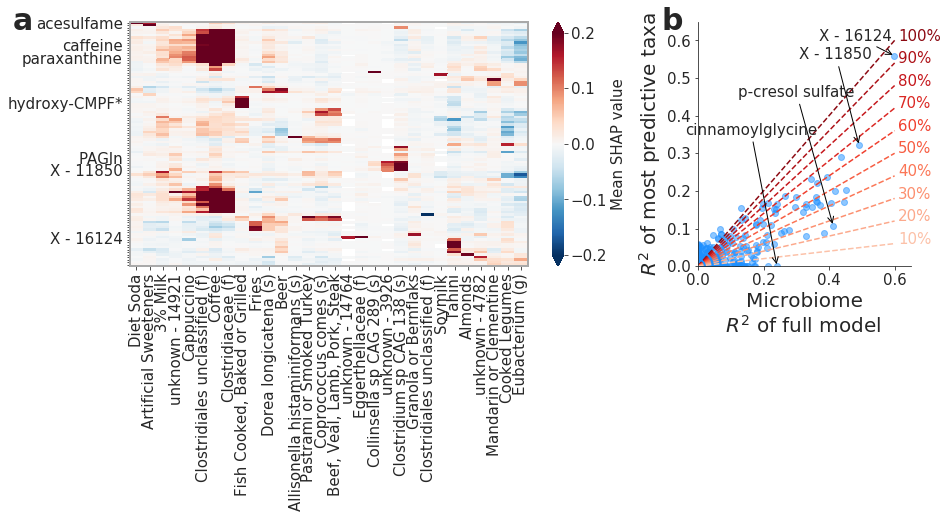

In [122]:
sns.set_style('ticks')
# set fontsizes
labels_fontsize = 20
tick_fontsize = 15

temp_data = shap_mat.copy()
# break heatmap into sections
rel_sp = metabs_no_nan[metabs_no_nan.CHEMICAL_ID.isin(temp_data.index)].SUPER_PATHWAY.unique().tolist()
rel_sp_dic, sp_pos_dic = {}, {}
for sp in rel_sp:
    print (sp)
    temp_data_sp = temp_data.reindex(metabs_no_nan[metabs_no_nan.SUPER_PATHWAY == sp].CHEMICAL_ID, axis=0).dropna().copy()
    if temp_data_sp.shape[0] == 1:  # don't include pathways with one metabolite
        continue
    cg = sns.clustermap(temp_data_sp, xticklabels=False, yticklabels=False, col_cluster=False, metric='correlation')
    plt.clf()  # cluster metabolites within each section
    rel_sp_dic[sp] = temp_data_sp.iloc[cg.dendrogram_row.reordered_ind, :]
    sp_pos_dic[sp] = temp_data_sp.shape[0] / 2.

# concat the new heatmap
temp_data = pd.concat([rel_sp_dic[sp] for sp in rel_sp_dic])
temp_data.rename(columns=feature_names_dic, inplace=True)

# cluster the columns
cg = sns.clustermap(temp_data, xticklabels=False, yticklabels=False, col_cluster=True, row_cluster=False, metric='correlation')#metric='correlation'
plt.clf()

# create the figure
fig = plt.figure(figsize=(14, 4.5))
gs = gridspec.GridSpec(1, 6, wspace=1.0, hspace=0.2)

main_heatmap = fig.add_subplot(gs[:, :4])
# main_heatmap_cbar = fig.add_subplot(gs[:, 40:43])
# main_heatmap_cbar.yaxis.label.set_size(labels_fontsize)

# replace CHEMICAL_ID with BIOCHEMICAL
y_ticks_labels = [metabs1[metabs1.CHEMICAL_ID == l].BIOCHEMICAL.values[0] for l in temp_data.iloc[:, :].index]
# show only these metabolite names
keep_metabs_names = ['p-cresol-glucoronide*', '3-indoxyl sulfate', 'X - 11850', 
                                    'X - 24243', 'X - 16124', 'glycodeoxycholate', '5-hydroxyhexanoate', 'hydroxy-CMPF*', 'acesulfame', 'caffeine', 
                                     'paraxanthine', 'phenylacetylglutamine', 'cholate', 
                                    'ursodeoxycholate', '3-methylxanthine', '4-ethylphenylsulfate']
metabs_short_names = {'phenylacetylglutamine':'PAGln'}
y_ticks_labels = [s if s in keep_metabs_names else '' for s in y_ticks_labels]
y_ticks_labels = [metabs_short_names[s] if s in metabs_short_names else s for s in y_ticks_labels]

# draw the heatmap
g_main = sns.heatmap(temp_data.iloc[:, cg.dendrogram_col.reordered_ind].clip(upper=0.2).clip(lower=-0.2),  
            xticklabels=True, yticklabels=y_ticks_labels, 
            ax=main_heatmap, cmap='RdBu_r', cbar=True, #cbar_ax=main_heatmap_cbar, 
            cbar_kws={'label': 'Mean SHAP value [avg. impact on model output]', 
                      'extend':'both', 'ticks':[-0.2, -0.1, 0, 0.1, 0.2]},
            mask=temp_data.iloc[:, cg.dendrogram_col.reordered_ind] == 0)
g_main.figure.axes[-1].set_ylabel('Mean SHAP value', size=tick_fontsize)
g_main.figure.axes[-1].tick_params(labelsize=tick_fontsize)
main_heatmap_cbar.tick_params(labelsize=tick_fontsize)
main_heatmap.set_ylabel('', fontsize=labels_fontsize)
main_heatmap.tick_params(labelsize=tick_fontsize)
xtickslabels = [s.get_text() for s in main_heatmap.get_xticklabels()]
xtickslabels = [s.split(' Freq')[0] for s in xtickslabels]  # edit the food names
xtickslabels = [s.split('SF_')[1].split('_wt')[0].split('_')[0] if 'SF_' in s else s for s in xtickslabels]
xtickslabels = [_find_closest_ancestry(s)[0] if s.startswith('k__') else s.strip() for s in xtickslabels]  # edit the bacteria names
main_heatmap.set_xticklabels(xtickslabels, fontsize=tick_fontsize, rotation=90, ha='center')
# color the border with grey
for _, spine in main_heatmap.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(2)
    spine.set_color('darkgrey')

# main_heatmap_super_pathway = fig.add_subplot(gs[:, 40:43])
# main_heatmap_super_pathway.set_yticks([])
# sp = metabs_no_nan.set_index('CHEMICAL_ID').loc[temp_data.index].SUPER_PATHWAY
# # assign each pathway with an int
# value_to_int = {value: i for i, value in enumerate(super_pathway_color.keys())}
# colors = mpl.colors.ListedColormap(['white' for w in super_pathway_color.keys()])  # only white
# # colors = mpl.colors.ListedColormap(super_pathway_color.values())  # use colors from figure 1

# g = sns.heatmap(pd.DataFrame(sp.replace(value_to_int)).astype(float), 
#                 cmap=colors, ax=main_heatmap_super_pathway, cbar=False, yticklabels=False)  # draw the super pathway heatmap
# main_heatmap_super_pathway.set_ylabel('')
# main_heatmap_super_pathway.set_xticklabels(['Super pathway'], fontsize=labels_fontsize, rotation=90, ha='center')

# # write the super pathways in the heatmap
# cum = 0
# for sp in rel_sp_dic:
#     g.add_patch(Rectangle((0, cum), 1, sp_pos_dic[sp]*2, fill=False, edgecolor='darkgrey', lw=2))
#     g_main.add_patch(Rectangle((0, cum), temp_data.shape[1], sp_pos_dic[sp]*2, fill=False, edgecolor='darkgrey', lw=2))
#     cum += sp_pos_dic[sp]
#     pep_aa_dic = {'Peptides':'Ptds', 'Amino acids':'AAs', 'Cofactors and Vitamins':'C&V'}
#     if sp in ['Peptides', 'Amino acids', 'Cofactors and Vitamins']:
#         main_heatmap_super_pathway.text(0.5, cum, pep_aa_dic[sp], ha='center', va='center', fontsize=labels_fontsize)    
#     else:
#         main_heatmap_super_pathway.text(0.5, cum, sp, rotation=90, fontsize=labels_fontsize, ha='center', va='center')
#     cum += sp_pos_dic[sp]
 
# for _, spine in main_heatmap_super_pathway.spines.items():
#     spine.set_visible(True)
#     spine.set_linewidth(2)
#     spine.set_color('darkgrey')

# Axes b-c

sns.set_style('ticks')
# x_end_gs = 48
additional_axes = []

temp_ind = mb_full_results[mb_full_results['Coefficient_of_determination'] > 0.1].index
mb_relative_r2 = mb_single_best_feature_res.loc[temp_ind, 'Coefficient_of_determination'].apply(lambda x: max(0, x)) / \
                           mb_full_results.loc[temp_ind, 'Coefficient_of_determination'].apply(lambda x: max(0, x))
print ('median single feature r2 of mb:', mb_relative_r2.median())
ax = fig.add_subplot(gs[0, 4:])
additional_axes.append(ax)
ax.plot(mb_full_results['Coefficient_of_determination'].apply(lambda x: max(0, x)), 
            mb_single_best_feature_res.loc[mb_full_results.index, 'Coefficient_of_determination'].apply(lambda x: max(0, x)), 
            'o', alpha=0.5, color='dodgerblue')
colors = sns.color_palette('Reds_r', 12)
lim = 0.6
for color, i in zip(colors, np.arange(1, 0.0, -0.1)):
    ax.plot([0., lim], [0, lim * i], '--', color=color)
    ax.text(x=lim+0.01, y= lim * i, s='%0.1d'%(i*100) + '%', color=color, fontsize=tick_fontsize)
    
for metab in ['X - 11850', 'X - 16124', '100001315', '100002253']:
    xy = (max(0, mb_full_results.loc[metab, 'Coefficient_of_determination']), max(0, mb_single_best_feature_res.loc[metab, 'Coefficient_of_determination']))
    xytext = [xy[0]-0.08, xy[1] +0.35]
    if xytext[1] > 0.7: xytext = [0.48, 0.6]
    if metab == 'X - 11850': xytext = [0.42, 0.55] 
    if metab == '100001315': xytext = [0.3, 0.45] 
    ax.annotate(metabs1[metabs1.CHEMICAL_ID == metab].BIOCHEMICAL.values[0], 
                        xy, 
                        xytext=xytext,
                        arrowprops={'arrowstyle':'->',  'color':'black'},
                        ha='center', fontsize=tick_fontsize)
ax.set_xlim((0, lim+0.05))
ax.set_ylim((0, lim+0.05))
ax.tick_params(labelsize=tick_fontsize)
ax.set_xlabel('Microbiome\n$R^2$ of full model ', fontsize=labels_fontsize)
ax.set_ylabel('$R^2$ of most predictive taxa', fontsize=labels_fontsize)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


fig.tight_layout()

plt.text(-0.27, 1., 'a', ha='center', va='center', transform=main_heatmap.transAxes, fontsize=30, weight='bold')
plt.text(-0.12, 1., 'b', ha='center', va='center', transform=additional_axes[0].transAxes, fontsize=30, weight='bold')
# plt.text(-0.15, 1., 'c', ha='center', va='center', transform=additional_axes[1].transAxes, fontsize=30, weight='bold')

plt.savefig(os.path.join(figure_dir, 'Figure_3_small.png'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(figure_dir, 'Figure_3.png'), dpi=1000, bbox_inches='tight')
plt.savefig(os.path.join(figure_dir, 'Figure_3.pdf'), dpi=1000, bbox_inches='tight')

Xenobiotics
Carbohydrates
Lipids
Amino acids
Peptides
Cofactors and Vitamins
Unknowns
median single feature r2 of mb: 0.3568455723271984


/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:142: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

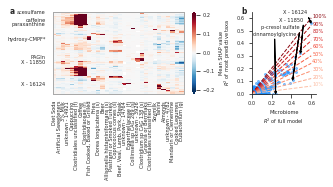

In [153]:
sns.set_style('white')
# set fontsizes
labels_fontsize = 5
tick_fontsize = 5

temp_data = shap_mat.copy()
# break heatmap into sections
rel_sp = metabs_no_nan[metabs_no_nan.CHEMICAL_ID.isin(temp_data.index)].SUPER_PATHWAY.unique().tolist()
rel_sp_dic, sp_pos_dic = {}, {}
for sp in rel_sp:
    print (sp)
    temp_data_sp = temp_data.reindex(metabs_no_nan[metabs_no_nan.SUPER_PATHWAY == sp].CHEMICAL_ID, axis=0).dropna().copy()
    if temp_data_sp.shape[0] == 1:  # don't include pathways with one metabolite
        continue
    cg = sns.clustermap(temp_data_sp, xticklabels=False, yticklabels=False, col_cluster=False, metric='correlation')
    plt.clf()  # cluster metabolites within each section
    rel_sp_dic[sp] = temp_data_sp.iloc[cg.dendrogram_row.reordered_ind, :]
    sp_pos_dic[sp] = temp_data_sp.shape[0] / 2.

# concat the new heatmap
temp_data = pd.concat([rel_sp_dic[sp] for sp in rel_sp_dic])
temp_data.rename(columns=feature_names_dic, inplace=True)

# cluster the columns
cg = sns.clustermap(temp_data, xticklabels=False, yticklabels=False, col_cluster=True, row_cluster=False, metric='correlation')#metric='correlation'
plt.clf()

# create the figure
fig = plt.figure(figsize=(4.724, 1.51))
gs = gridspec.GridSpec(1, 6, wspace=2.4, hspace=0.2)

main_heatmap = fig.add_subplot(gs[:, :4])
# main_heatmap_cbar = fig.add_subplot(gs[:, 40:43])
# main_heatmap_cbar.yaxis.label.set_size(labels_fontsize)

# replace CHEMICAL_ID with BIOCHEMICAL
y_ticks_labels = [metabs1[metabs1.CHEMICAL_ID == l].BIOCHEMICAL.values[0] for l in temp_data.iloc[:, :].index]
# show only these metabolite names
keep_metabs_names = ['p-cresol-glucoronide*', '3-indoxyl sulfate', 'X - 11850', 
                                    'X - 24243', 'X - 16124', 'glycodeoxycholate', '5-hydroxyhexanoate', 'hydroxy-CMPF*', 'acesulfame', 'caffeine', 
                                     'paraxanthine', 'phenylacetylglutamine', 'cholate', 
                                    'ursodeoxycholate', '3-methylxanthine', '4-ethylphenylsulfate']
metabs_short_names = {'phenylacetylglutamine':'PAGln'}
y_ticks_labels = [s if s in keep_metabs_names else '' for s in y_ticks_labels]
y_ticks_labels = [metabs_short_names[s] if s in metabs_short_names else s for s in y_ticks_labels]

# draw the heatmap
g_main = sns.heatmap(temp_data.iloc[:, cg.dendrogram_col.reordered_ind].clip(upper=0.2).clip(lower=-0.2),  
            xticklabels=True, yticklabels=y_ticks_labels, 
            ax=main_heatmap, cmap='RdBu_r', cbar=True, #cbar_ax=main_heatmap_cbar, 
            cbar_kws={'label': 'Mean SHAP value [avg. impact on model output]', 
                      'extend':'both', 'ticks':[-0.2, -0.1, 0, 0.1, 0.2]},
            mask=temp_data.iloc[:, cg.dendrogram_col.reordered_ind] == 0)
g_main.figure.axes[-1].set_ylabel('Mean SHAP value', size=tick_fontsize)
g_main.figure.axes[-1].tick_params(labelsize=tick_fontsize)
main_heatmap_cbar.tick_params(labelsize=tick_fontsize)
main_heatmap.set_ylabel('', fontsize=labels_fontsize)
main_heatmap.tick_params(labelsize=tick_fontsize)
xtickslabels = [s.get_text() for s in main_heatmap.get_xticklabels()]
xtickslabels = [s.split(' Freq')[0] for s in xtickslabels]  # edit the food names
xtickslabels = [s.split('SF_')[1].split('_wt')[0].split('_')[0] if 'SF_' in s else s for s in xtickslabels]
xtickslabels = [_find_closest_ancestry(s)[0] if s.startswith('k__') else s.strip() for s in xtickslabels]  # edit the bacteria names
main_heatmap.set_xticklabels(xtickslabels, fontsize=tick_fontsize, rotation=90, ha='center')
# color the border with grey
for _, spine in main_heatmap.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(1)
    spine.set_color('darkgrey')

# main_heatmap_super_pathway = fig.add_subplot(gs[:, 40:43])
# main_heatmap_super_pathway.set_yticks([])
# sp = metabs_no_nan.set_index('CHEMICAL_ID').loc[temp_data.index].SUPER_PATHWAY
# # assign each pathway with an int
# value_to_int = {value: i for i, value in enumerate(super_pathway_color.keys())}
# colors = mpl.colors.ListedColormap(['white' for w in super_pathway_color.keys()])  # only white
# # colors = mpl.colors.ListedColormap(super_pathway_color.values())  # use colors from figure 1

# g = sns.heatmap(pd.DataFrame(sp.replace(value_to_int)).astype(float), 
#                 cmap=colors, ax=main_heatmap_super_pathway, cbar=False, yticklabels=False)  # draw the super pathway heatmap
# main_heatmap_super_pathway.set_ylabel('')
# main_heatmap_super_pathway.set_xticklabels(['Super pathway'], fontsize=labels_fontsize, rotation=90, ha='center')

# # write the super pathways in the heatmap
# cum = 0
# for sp in rel_sp_dic:
#     g.add_patch(Rectangle((0, cum), 1, sp_pos_dic[sp]*2, fill=False, edgecolor='darkgrey', lw=2))
#     g_main.add_patch(Rectangle((0, cum), temp_data.shape[1], sp_pos_dic[sp]*2, fill=False, edgecolor='darkgrey', lw=2))
#     cum += sp_pos_dic[sp]
#     pep_aa_dic = {'Peptides':'Ptds', 'Amino acids':'AAs', 'Cofactors and Vitamins':'C&V'}
#     if sp in ['Peptides', 'Amino acids', 'Cofactors and Vitamins']:
#         main_heatmap_super_pathway.text(0.5, cum, pep_aa_dic[sp], ha='center', va='center', fontsize=labels_fontsize)    
#     else:
#         main_heatmap_super_pathway.text(0.5, cum, sp, rotation=90, fontsize=labels_fontsize, ha='center', va='center')
#     cum += sp_pos_dic[sp]
 
# for _, spine in main_heatmap_super_pathway.spines.items():
#     spine.set_visible(True)
#     spine.set_linewidth(2)
#     spine.set_color('darkgrey')

# Axes b-c

sns.set_style('ticks')
# x_end_gs = 48
additional_axes = []

temp_ind = mb_full_results[mb_full_results['Coefficient_of_determination'] > 0.1].index
mb_relative_r2 = mb_single_best_feature_res.loc[temp_ind, 'Coefficient_of_determination'].apply(lambda x: max(0, x)) / \
                           mb_full_results.loc[temp_ind, 'Coefficient_of_determination'].apply(lambda x: max(0, x))
print ('median single feature r2 of mb:', mb_relative_r2.median())
ax = fig.add_subplot(gs[0, 4:])
additional_axes.append(ax)
ax.plot(mb_full_results['Coefficient_of_determination'].apply(lambda x: max(0, x)), 
            mb_single_best_feature_res.loc[mb_full_results.index, 'Coefficient_of_determination'].apply(lambda x: max(0, x)), 
            'o', alpha=0.5, color='dodgerblue', markersize=2)
colors = sns.color_palette('Reds_r', 12)
lim = 0.6
for color, i in zip(colors, np.arange(1, 0.0, -0.1)):
    ax.plot([0., lim], [0, lim * i], '--', color=color, linewidth=1)
    ax.text(x=lim+0.01, y= lim * i, s='%0.1d'%(i*100) + '%', color=color, fontsize=tick_fontsize)
    
for metab in ['X - 11850', 'X - 16124', '100001315', '100002253']:
    xy = (max(0, mb_full_results.loc[metab, 'Coefficient_of_determination']), max(0, mb_single_best_feature_res.loc[metab, 'Coefficient_of_determination']))
    xytext = [xy[0]-0.01, xy[1] +0.46]
    if xytext[1] > 0.7: xytext = [0.44, 0.63]
    if metab == 'X - 11850': xytext = [0.4, 0.57] 
    if metab == '100001315': xytext = [0.29, 0.51] 
    ax.annotate(metabs1[metabs1.CHEMICAL_ID == metab].BIOCHEMICAL.values[0], 
                        xy, 
                        xytext=xytext,
                        arrowprops=dict(color='black', width=0.2, headwidth=2, headlength=2),
                        ha='center', fontsize=tick_fontsize)
ax.set_xlim((0, lim+0.05))
ax.set_ylim((0, lim+0.05))
ax.tick_params(labelsize=tick_fontsize)
ax.set_xlabel('Microbiome\n$R^2$ of full model ', fontsize=labels_fontsize)
ax.set_ylabel('$R^2$ of most predictive taxa', fontsize=labels_fontsize)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


fig.tight_layout()

plt.text(-0.31, 1., 'a', ha='center', va='center', transform=main_heatmap.transAxes, fontsize=labels_fontsize*1.5, weight='bold')
plt.text(-0.12, 1., 'b', ha='center', va='center', transform=additional_axes[0].transAxes, fontsize=labels_fontsize*1.5, weight='bold')
# plt.text(-0.15, 1., 'c', ha='center', va='center', transform=additional_axes[1].transAxes, fontsize=30, weight='bold')

plt.savefig(os.path.join(figure_dir, 'Figure_3_small.png'), dpi=300, bbox_inches='tight')
# plt.savefig(os.path.join(figure_dir, 'Figure_3.png'), dpi=1000, bbox_inches='tight')
plt.savefig(os.path.join(figure_dir, 'Figure_3.pdf'), dpi=500, bbox_inches='tight')

In [125]:
for s in xtickslabels:
    print (s)

Diet Soda
Artificial Sweeteners
3% Milk
unknown - 14921
Cappuccino
Clostridiales unclassified (f)
Coffee
Clostridiaceae (f)
Fish Cooked, Baked or Grilled
Fries
Dorea longicatena (s)
Beer
Allisonella histaminiformans (s)
Pastrami or Smoked Turkey
Coprococcus comes (s)
Beef, Veal, Lamb, Pork, Steak
unknown - 14764
Eggerthellaceae (f)
Collinsella sp CAG 289 (s)
unknown - 3926
Clostridium sp CAG 138 (s)
Granola or Bernflaks
Clostridiales unclassified (f)
Soymilk
Tahini
Almonds
unknown - 4782
Mandarin or Clementine
Cooked Legumes
Eubacterium (g)


In [51]:
th = 0.05
at_least_1_over_01 = (mb_diet_ot_res['Coefficient_of_determination'] > th ) | (diet_ot_res.loc[mb_diet_ot_res.index, 'Coefficient_of_determination'] > th)
diff = mb_diet_ot_res.loc[at_least_1_over_01, 'Coefficient_of_determination'].clip(lower=0.0) - diet_ot_res.loc[at_least_1_over_01, 'Coefficient_of_determination'].clip(lower=0.0)
print ('min:', diff.min(), 'max:', diff.max(), 'mean:', diff.mean(), 'median:', diff.median())

min: -0.06616370404093952 max: 0.6262007880068761 mean: 0.038132686594755445 median: 0.021194427432668868


In [52]:
(diff > 0).sum() / diff.shape[0]

0.6623093681917211

# examine how the permuted MB did

In [19]:
permuted_resutls = pd.read_csv('../technical_noise/RSCV/LightGBM/metabolomics_shap_ot0.05_mb-permuted_diet/results.csv', index_col=0).sort_index()

th = 0.05
at_least_1_over_01 = (mb_diet_ot_res['Coefficient_of_determination'] > th ) | (diet_ot_res.loc[permuted_resutls.index, 'Coefficient_of_determination'] > th)
diff = permuted_resutls.loc[at_least_1_over_01, 'Coefficient_of_determination'].clip(lower=0.0) - diet_ot_res.loc[at_least_1_over_01, 'Coefficient_of_determination'].clip(lower=0.0)
print ('min:', diff.min(), 'max:', diff.max(), 'mean:', diff.mean(), 'median:', diff.median())

min: -0.0917851361990214 max: 0.07436694207432426 mean: -0.018603821243503432 median: -0.017644143002160745


In [20]:
(diff > 0).sum() / diff.shape[0]

0.1786492374727669

# Supp

In [121]:
r2_col = 'Coefficient_of_determination'
pd.concat((mb_diet_ot_res[[r2_col]].rename(columns={r2_col:'Diet and Microbiome R2'}), 
           permuted_resutls[[r2_col]].rename(columns={r2_col:'Diet and Permuted microbiome R2'})), axis=1)\
            .to_csv('Supp_table_r2_diet+mb_diet+permuted-mb.csv')

pd.concat((diet_ot_res[[r2_col]].rename(columns={r2_col:'Diet R2'}), 
           mb_ot_res[[r2_col]].rename(columns={r2_col:'Microbiome R2'})), axis=1)\
            .to_csv('Supp_table_r2_diet_mb.csv')

### Extended data figure 7

In [11]:
mb_predictions = pd.read_csv('/net/mraid08/export/jafar/Microbiome/Analyses/Noamba/Metabolon/technical_noise/RSCV/LightGBM/metabolomics_MB_daphna_LONG5_S/predictions_df.csv', index_col=0)
diet_predictions = pd.read_csv('/net/mraid08/export/jafar/Microbiome/Analyses/Noamba/Metabolon/technical_noise/RSCV/LightGBM/metabolomics_ffq+diet0.05/predictions_df.csv', index_col=0)

In [97]:
diet_pred = pd.read_csv('../technical_noise/RSCV/LightGBM/metabolomics_shap_ot0.05_ffq+diet0.05/predictions_df.csv', index_col=0)
diet_res = pd.read_csv('../technical_noise/RSCV/LightGBM/metabolomics_shap_ot0.05_ffq+diet0.05/results.csv', index_col=0)
diet_abs_shap = pd.read_csv('../technical_noise/RSCV/LightGBM/metabolomics_shap_ot0.05_ffq+diet0.05/abs_shap.csv', index_col=0)
diet_abs_signed_shap = pd.read_csv('../technical_noise/RSCV/LightGBM/metabolomics_shap_ot0.05_ffq+diet0.05/abs_signed_shap.csv', index_col=0)

mb_pred = pd.read_csv('../technical_noise/RSCV/LightGBM/metabolomics_shap_ot0.05_MB_daphna_LONG5_S//predictions_df.csv', index_col=0)
mb_res = pd.read_csv('../technical_noise/RSCV/LightGBM/metabolomics_shap_ot0.05_MB_daphna_LONG5_S/results.csv', index_col=0)
mb_abs_shap = pd.read_csv('../technical_noise/RSCV/LightGBM/metabolomics_shap_ot0.05_MB_daphna_LONG5_S/abs_shap.csv', index_col=0)
mb_abs_signed_shap = pd.read_csv('../technical_noise/RSCV/LightGBM/metabolomics_shap_ot0.05_MB_daphna_LONG5_S/abs_signed_shap.csv', index_col=0)

max_res = pd.concat((mb_res, diet_res), sort=True).reset_index().groupby('index').apply(lambda x: x.loc[x.Coefficient_of_determination.idxmax()])
abs_shap = pd.concat((diet_abs_shap, mb_abs_shap), axis=1)
abs_signed_shap = pd.concat((diet_abs_signed_shap, mb_abs_signed_shap), axis=1)


col2drop = ['Coffee Freq', 'Cooked Cereal such as Oatmeal Porridge Freq', 'Nuts, almonds, pistachios Freq', 'Tahini Salad Freq', 'SF_Beer_wt', 
            'Fish (not Tuna) Pickled, Dried, Smoked, Canned Freq', 'Canned Tuna or Tuna Salad Freq', 'SF_Milk_wt', 'SF_Sugar substitute_wt', 'SF_Apple_wt']
chemid = max_res.sort_values('pearson_p').head(150).index

top_features = abs_shap.drop(col2drop, axis=1).loc[chemid].max().sort_values().tail(40).index
shap_mat = abs_signed_shap.loc[chemid, top_features].copy()

Xenobiotics
Carbohydrates
Lipids
Amino acids
Peptides
Cofactors and Vitamins
Unknowns


/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:227: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

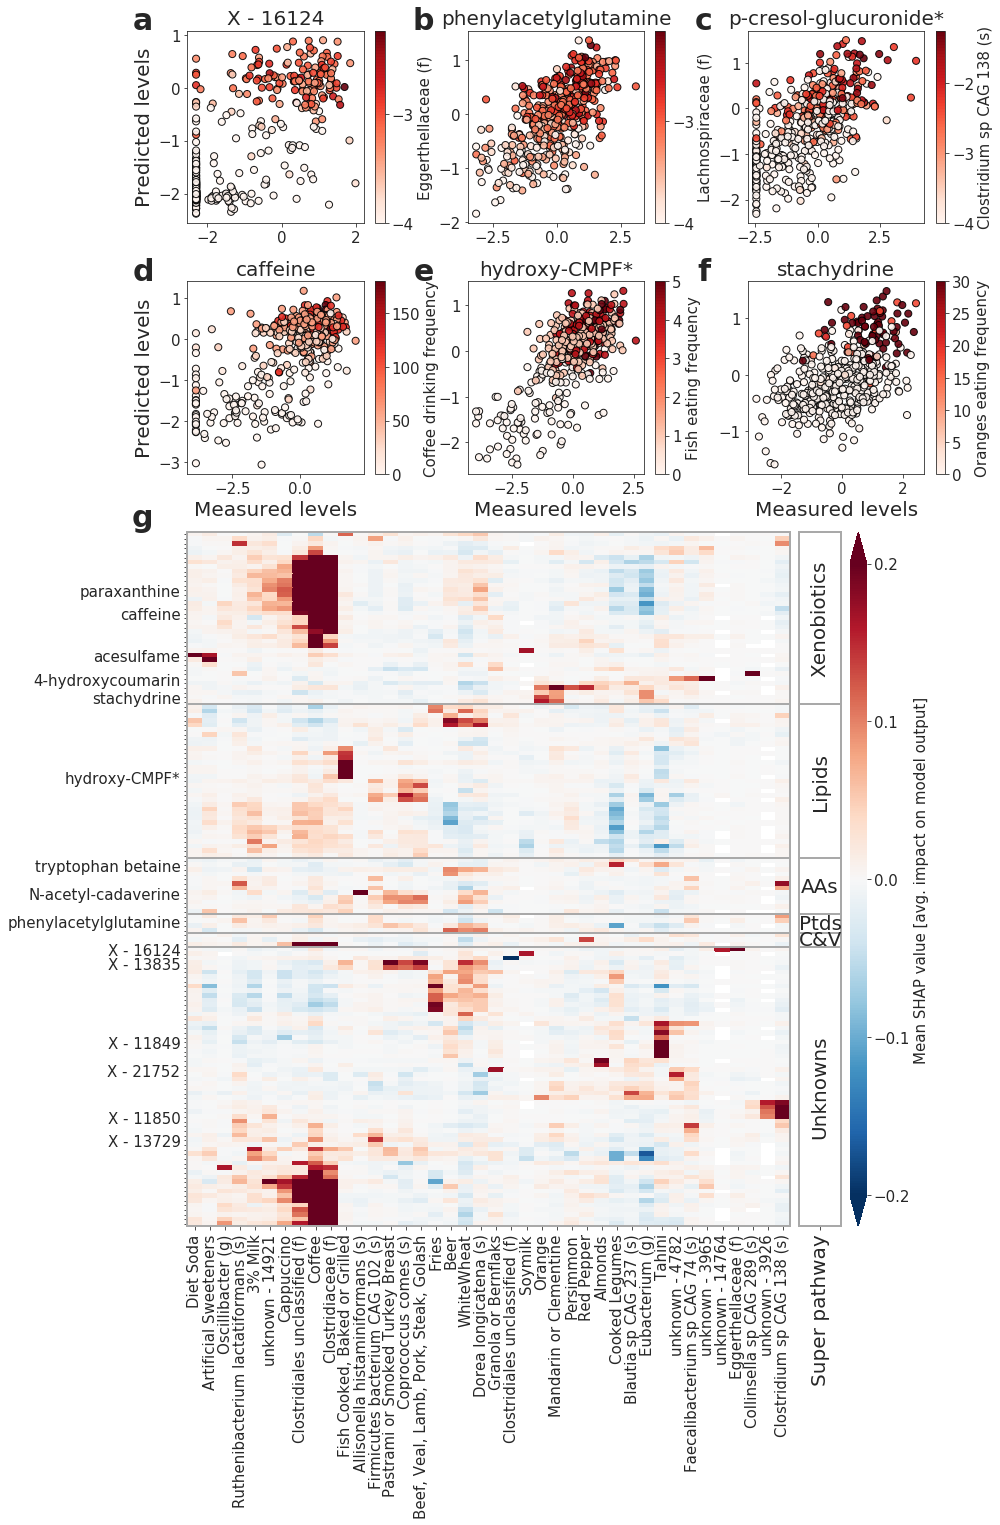

In [99]:
sns.set_style('ticks')
# set fontsizes
labels_fontsize = 20
tick_fontsize = 15

temp_data = shap_mat.copy()
# break heatmap into sections
rel_sp = metabs_no_nan[metabs_no_nan.CHEMICAL_ID.isin(temp_data.index)].SUPER_PATHWAY.unique().tolist()
rel_sp_dic, sp_pos_dic = {}, {}
for sp in rel_sp:
    print (sp)
    temp_data_sp = temp_data.reindex(metabs_no_nan[metabs_no_nan.SUPER_PATHWAY == sp].CHEMICAL_ID, axis=0).dropna().copy()
    if temp_data_sp.shape[0] == 1:  # don't include pathways with one metabolite
        continue
    cg = sns.clustermap(temp_data_sp, xticklabels=False, yticklabels=False, col_cluster=False, metric='correlation')
    plt.clf()  # cluster metabolites within each section
    rel_sp_dic[sp] = temp_data_sp.iloc[cg.dendrogram_row.reordered_ind, :]
    sp_pos_dic[sp] = temp_data_sp.shape[0] / 2.

# concat the new heatmap
temp_data = pd.concat([rel_sp_dic[sp] for sp in rel_sp_dic])

# cluster the columns
cg = sns.clustermap(temp_data, xticklabels=False, yticklabels=False, col_cluster=True, row_cluster=False, metric='correlation')#metric='correlation'
plt.clf()



# create the figure
fig = plt.figure(figsize=(14, 22))
n_cols = 27
gs = gridspec.GridSpec(5, 31, wspace=0.5, hspace=0.3)

# fig = plt.figure(figsize=(16, 13))
# gs = gridspec.GridSpec(3, 3, wspace=0.3, hspace=0.4)

labels_fontsize = 20
tick_fontsize = 15
list_of_axes = []

ax = fig.add_subplot(gs[0, :int(n_cols/3)])
list_of_axes.append(ax)
c = 'X - 16124'
top_shap = mb_full_abs_shap.loc[c].sort_values().tail(1).index.values[0]
name = _find_closest_ancestry(top_shap)[0]
scat = ax.scatter(single_metabs[c], mb_predictions.reindex(single_metabs.index, axis=0)[c], 
                                                           c=mb_full.reindex(single_metabs.index, axis=0)[top_shap].apply(np.log10), cmap='Reds', edgecolor='black', s=50, alpha=0.9)
cb1 = fig.colorbar(scat, ax=ax, ticks=[-4, -3, -2, -1])
cb1.set_label(name, fontsize=tick_fontsize)
cb1.ax.tick_params(labelsize=tick_fontsize)
cb1.ax.yaxis.label.set_size(tick_fontsize)
ax.tick_params(labelsize=tick_fontsize)
# cb1.ax.set_yticklabels(['1e-4', '1e-3', '1e-2', '1e-1'])
r, p = pearsonr_rmna(single_metabs[c], mb_predictions.loc[single_metabs.index, c])
# ax.set_title(metabs1[metabs1.CHEMICAL_ID == c].BIOCHEMICAL.values[0] + ' (R=%0.2f)'%(r), fontsize=labels_fontsize)
ax.set_title(metabs1[metabs1.CHEMICAL_ID == c].BIOCHEMICAL.values[0], fontsize=labels_fontsize)
# ax.set_xlabel('Measured levels', fontsize=labels_fontsize)
ax.set_ylabel('Predicted levels', fontsize=labels_fontsize)

ax = fig.add_subplot(gs[0, int(n_cols/3)+2:int(2*n_cols/3)+2])
list_of_axes.append(ax)
c = '100001417'
top_shap = mb_full_abs_shap.loc[c].sort_values().tail(1).index.values[0]
name = _find_closest_ancestry(top_shap)[0]
scat = ax.scatter(single_metabs[c], mb_predictions.reindex(single_metabs.index, axis=0)[c], 
                  c=mb_full.reindex(single_metabs.index, axis=0)[top_shap].apply(np.log10), cmap='Reds', edgecolor='black', s=50, alpha=0.9)
cb1 = fig.colorbar(scat, ax=ax, ticks=[-4, -3, -2, -1])
cb1.set_label(name, fontsize=tick_fontsize)
cb1.ax.tick_params(labelsize=tick_fontsize)
cb1.ax.yaxis.label.set_size(tick_fontsize)
ax.tick_params(labelsize=tick_fontsize)
# cb1.ax.set_yticklabels(['1e-4', '1e-3', '1e-2', '1e-1'])
r, p = pearsonr_rmna(single_metabs[c], mb_predictions.loc[single_metabs.index, c])
# ax.set_title(metabs1[metabs1.CHEMICAL_ID == c].BIOCHEMICAL.values[0] + ' (R=%0.2f)'%(r), fontsize=labels_fontsize)
ax.set_title(metabs1[metabs1.CHEMICAL_ID == c].BIOCHEMICAL.values[0], fontsize=labels_fontsize)
# ax.set_xlabel('Measured levels', fontsize=labels_fontsize)
# ax.set_ylabel('Predicted levels', fontsize=labels_fontsize)

ax = fig.add_subplot(gs[0, int(2*n_cols/3)+4:])
list_of_axes.append(ax)
c = '100006191'
top_shap = mb_full_abs_shap.loc[c].sort_values().tail(1).index.values[0]
name = _find_closest_ancestry(top_shap)[0]
scat = ax.scatter(single_metabs[c], mb_predictions.reindex(single_metabs.index, axis=0)[c], 
                  c=mb_full.reindex(single_metabs.index, axis=0)[top_shap].apply(np.log10), cmap='Reds', edgecolor='black', s=50, alpha=0.9)
cb1 = fig.colorbar(scat, ax=ax, ticks=[-4, -3, -2, -1])
cb1.set_label(name, fontsize=tick_fontsize)
cb1.ax.tick_params(labelsize=tick_fontsize)
cb1.ax.yaxis.label.set_size(tick_fontsize)
ax.tick_params(labelsize=tick_fontsize)
# cb1.ax.set_yticklabels(['1e-4', '1e-3', '1e-2', '1e-1'])
r, p = pearsonr_rmna(single_metabs[c], mb_predictions.loc[single_metabs.index, c])
# ax.set_title(metabs1[metabs1.CHEMICAL_ID == c].BIOCHEMICAL.values[0] + ' (R=%0.2f)'%(r), fontsize=labels_fontsize)
ax.set_title(metabs1[metabs1.CHEMICAL_ID == c].BIOCHEMICAL.values[0], fontsize=labels_fontsize)
# ax.set_xlabel('Measured levels', fontsize=labels_fontsize)
# ax.set_ylabel('Predicted levels', fontsize=labels_fontsize)

ax = fig.add_subplot(gs[1, :int(n_cols/3)])
list_of_axes.append(ax)
c = '849'
top_shap = diet_full_abs_shap.loc[c].sort_values().tail(1).index.values[0]
name = 'Coffee drinking frequency'
scat = ax.scatter(single_metabs[c], diet_predictions.reindex(single_metabs.index, axis=0)[c], 
                  c=diet_full.reindex(single_metabs.index, axis=0)[top_shap], cmap='Reds', edgecolor='black', s=50, alpha=0.9)
cb1 = fig.colorbar(scat, ax=ax)
cbar_ticks = [s.get_text() for s in cb1.ax.get_yticklabels()]
cb1.set_label(name, fontsize=tick_fontsize)
cb1.ax.tick_params(labelsize=tick_fontsize)
cb1.ax.yaxis.label.set_size(tick_fontsize)
ax.tick_params(labelsize=tick_fontsize)
# cb1.ax.set_yticklabels(['0'] + ['']*(len(cbar_ticks)-2) + ['1'])
r, p = pearsonr_rmna(single_metabs[c], diet_predictions.loc[single_metabs.index, c])
# ax.set_title(metabs1[metabs1.CHEMICAL_ID == c].BIOCHEMICAL.values[0] + ' (R=%0.2f)'%(r), fontsize=labels_fontsize)
ax.set_title(metabs1[metabs1.CHEMICAL_ID == c].BIOCHEMICAL.values[0], fontsize=labels_fontsize)
ax.set_xlabel('Measured levels', fontsize=labels_fontsize)
ax.set_ylabel('Predicted levels', fontsize=labels_fontsize)

ax = fig.add_subplot(gs[1, int(n_cols/3)+2:int(2*n_cols/3)+2])
list_of_axes.append(ax)
c = '100019794'
top_shap = diet_full_abs_shap.loc[c].sort_values().tail(1).index.values[0]
name = 'Fish eating frequency'
scat = ax.scatter(single_metabs[c], diet_predictions.reindex(single_metabs.index, axis=0)[c], 
                  c=diet_full.reindex(single_metabs.index, axis=0)[top_shap].clip(upper=5), cmap='Reds', edgecolor='black', s=50, alpha=0.9)
cb1 = fig.colorbar(scat, ax=ax)
cbar_ticks = [s.get_text() for s in cb1.ax.get_yticklabels()]
cb1.set_label(name, fontsize=tick_fontsize)
cb1.ax.tick_params(labelsize=tick_fontsize)
cb1.ax.yaxis.label.set_size(tick_fontsize)
ax.tick_params(labelsize=tick_fontsize)
# cb1.ax.set_yticklabels(['0'] + ['']*(len(cbar_ticks)-2) + ['1'])
r, p = pearsonr_rmna(single_metabs[c], diet_predictions.loc[single_metabs.index, c])
# ax.set_title(metabs1[metabs1.CHEMICAL_ID == c].BIOCHEMICAL.values[0] + ' (R=%0.2f)'%(r), fontsize=labels_fontsize)
ax.set_title(metabs1[metabs1.CHEMICAL_ID == c].BIOCHEMICAL.values[0], fontsize=labels_fontsize)
ax.set_xlabel('Measured levels', fontsize=labels_fontsize)
# ax.set_ylabel('Predicted levels', fontsize=labels_fontsize)

ax = fig.add_subplot(gs[1, int(2*n_cols/3)+4:])
list_of_axes.append(ax)
c = '100001296'
top_shap = diet_full_abs_shap.loc[c].sort_values().tail(1).index.values[0]
name ='Oranges eating frequency'
scat = ax.scatter(single_metabs[c], diet_predictions.reindex(single_metabs.index, axis=0)[c], 
                  c=diet_full.reindex(single_metabs.index, axis=0)[top_shap].clip(upper=30), cmap='Reds', edgecolor='black', s=50, alpha=0.9)
cb1 = fig.colorbar(scat, ax=ax)
cbar_ticks = [s.get_text() for s in cb1.ax.get_yticklabels()]
cb1.set_label(name, fontsize=tick_fontsize)
cb1.ax.tick_params(labelsize=tick_fontsize)
cb1.ax.yaxis.label.set_size(tick_fontsize)
ax.tick_params(labelsize=tick_fontsize)
# cb1.ax.set_yticklabels(['0'] + ['']*(len(cbar_ticks)-2) + ['1'])
r, p = pearsonr_rmna(single_metabs[c], diet_predictions.loc[single_metabs.index, c])
# ax.set_title(metabs1[metabs1.CHEMICAL_ID == c].BIOCHEMICAL.values[0] + ' (R=%0.2f)'%(r), fontsize=labels_fontsize)
ax.set_title(metabs1[metabs1.CHEMICAL_ID == c].BIOCHEMICAL.values[0], fontsize=labels_fontsize)
ax.set_xlabel('Measured levels', fontsize=labels_fontsize)
# ax.set_ylabel('Predicted levels', fontsize=labels_fontsize)



main_heatmap = fig.add_subplot(gs[2:, :n_cols-3])
# main_heatmap_cbar = fig.add_subplot(gs[:, 40:43])
# main_heatmap_cbar.yaxis.label.set_size(labels_fontsize)

# replace CHEMICAL_ID with BIOCHEMICAL
y_ticks_labels = [metabs1[metabs1.CHEMICAL_ID == l].BIOCHEMICAL.values[0] for l in temp_data.iloc[:, :].index]
# show only these metabolite names
keep_metabs_names = ['p-cresol-glucoronide*', 'tryptophan betaine', '3-indoxyl sulfate', 'X - 13729', 'X - 11850', 'X - 11849', 'X - 13835',
                                    'X - 24243', 'X - 16124', 'glycodeoxycholate', '5-hydroxyhexanoate', 'hydroxy-CMPF*', 'acesulfame', 'caffeine', 
                                     'paraxanthine', 'stachydrine', 'phenylacetylglutamine', 'cholate', '4-hydroxycoumarin', 'N-acetyl-cadaverine', 
                                    'ursodeoxycholate', 'X - 21752', '3-methylxanthine', '4-ethylphenylsulfate']
y_ticks_labels = [s if s in keep_metabs_names else '' for s in y_ticks_labels]

# draw the heatmap
main_heatmap_cbar = fig.add_subplot(gs[2:, n_cols-1])
g_main = sns.heatmap(temp_data.iloc[:, cg.dendrogram_col.reordered_ind].clip(upper=0.2).clip(lower=-0.2),  
            xticklabels=True, yticklabels=y_ticks_labels, 
            ax=main_heatmap, cmap='RdBu_r', cbar_ax=main_heatmap_cbar, 
            cbar_kws={'label': 'Mean SHAP value [avg. impact on model output]', 
                      'extend':'both', 'ticks':[-0.2, -0.1, 0, 0.1, 0.2]},
            mask=temp_data.iloc[:, cg.dendrogram_col.reordered_ind] == 0)
main_heatmap_cbar.tick_params(labelsize=tick_fontsize)
g_main.figure.axes[-1].set_ylabel('Mean SHAP value [avg. impact on model output]', size=tick_fontsize)
main_heatmap.set_ylabel('', fontsize=labels_fontsize)
main_heatmap.tick_params(labelsize=tick_fontsize)
xtickslabels = [s.get_text() for s in main_heatmap.get_xticklabels()]
xtickslabels = [s.split(' Freq')[0] for s in xtickslabels]  # edit the food names
xtickslabels = [s.split('SF_')[1].split('_wt')[0].split('_')[0] if 'SF_' in s else s for s in xtickslabels]
xtickslabels = [_find_closest_ancestry(s)[0] if s.startswith('k__') else s.strip() for s in xtickslabels]  # edit the bacteria names
main_heatmap.set_xticklabels(xtickslabels, fontsize=tick_fontsize)
# color the border with grey
for _, spine in main_heatmap.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(2)
    spine.set_color('darkgrey')

main_heatmap_super_pathway = fig.add_subplot(gs[2:, n_cols-3:n_cols-1])
main_heatmap_super_pathway.set_yticks([])
sp = metabs_no_nan.set_index('CHEMICAL_ID').loc[temp_data.index].SUPER_PATHWAY
# assign each pathway with an int
value_to_int = {value: i for i, value in enumerate(super_pathway_color.keys())}
colors = mpl.colors.ListedColormap(['white' for w in super_pathway_color.keys()])  # only white
# colors = mpl.colors.ListedColormap(super_pathway_color.values())  # use colors from figure 1

g = sns.heatmap(pd.DataFrame(sp.replace(value_to_int)).astype(float), 
                cmap=colors, ax=main_heatmap_super_pathway, cbar=False, yticklabels=False)  # draw the super pathway heatmap
main_heatmap_super_pathway.set_ylabel('')
main_heatmap_super_pathway.set_xticklabels(['Super pathway'], fontsize=labels_fontsize, rotation=90, ha='center')

# write the super pathways in the heatmap
cum = 0
for sp in rel_sp_dic:
    g.add_patch(Rectangle((0, cum), 1, sp_pos_dic[sp]*2, fill=False, edgecolor='darkgrey', lw=2))
    g_main.add_patch(Rectangle((0, cum), temp_data.shape[1], sp_pos_dic[sp]*2, fill=False, edgecolor='darkgrey', lw=2))
    cum += sp_pos_dic[sp]
    pep_aa_dic = {'Peptides':'Ptds', 'Amino acids':'AAs', 'Cofactors and Vitamins':'C&V'}
    if sp in ['Peptides', 'Amino acids', 'Cofactors and Vitamins']:
        main_heatmap_super_pathway.text(0.5, cum, pep_aa_dic[sp], ha='center', va='center', fontsize=labels_fontsize)    
    else:
        main_heatmap_super_pathway.text(0.5, cum, sp, rotation=90, fontsize=labels_fontsize, ha='center', va='center')
    cum += sp_pos_dic[sp]
 
for _, spine in main_heatmap_super_pathway.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(2)
    spine.set_color('darkgrey')

fig.tight_layout()

for ax, letter in zip(list_of_axes, ['a', 'b', 'c', 'd', 'e', 'f']):
    plt.text(-0.25, 1.05, letter, ha='center', va='center', transform=ax.transAxes, fontsize=30, weight='bold')
plt.text(-0.075, 1.02, 'g', ha='center', va='center', transform=g_main.transAxes, fontsize=30, weight='bold')

plt.savefig(os.path.join(figure_dir, 'Extended_Data_Figure_7_small.png'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(figure_dir, 'Extended_Data_Figure_7.png'), dpi=1000, bbox_inches='tight')
plt.savefig(os.path.join(figure_dir, 'Extended_Data_Figure_7.pdf'), dpi=1000, bbox_inches='tight')

### Extended Data Fig. 8

In [100]:
mb_full_phyla = mb_full.copy()
mb_full_phyla.columns = [s.split('|')[1].split('__')[1] for s in mb_full_phyla.columns]
mb_full_phyla = mb_full_phyla.T.reset_index().groupby('index').sum()

mb_full_phyla = mb_full_phyla.apply(lambda x: x/x.sum(), axis=0)

mb_full_phyla = mb_full_phyla.loc[mb_full_phyla.mean(1).sort_values(ascending=False).index].T.sort_values('Firmicutes', ascending=False)

/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


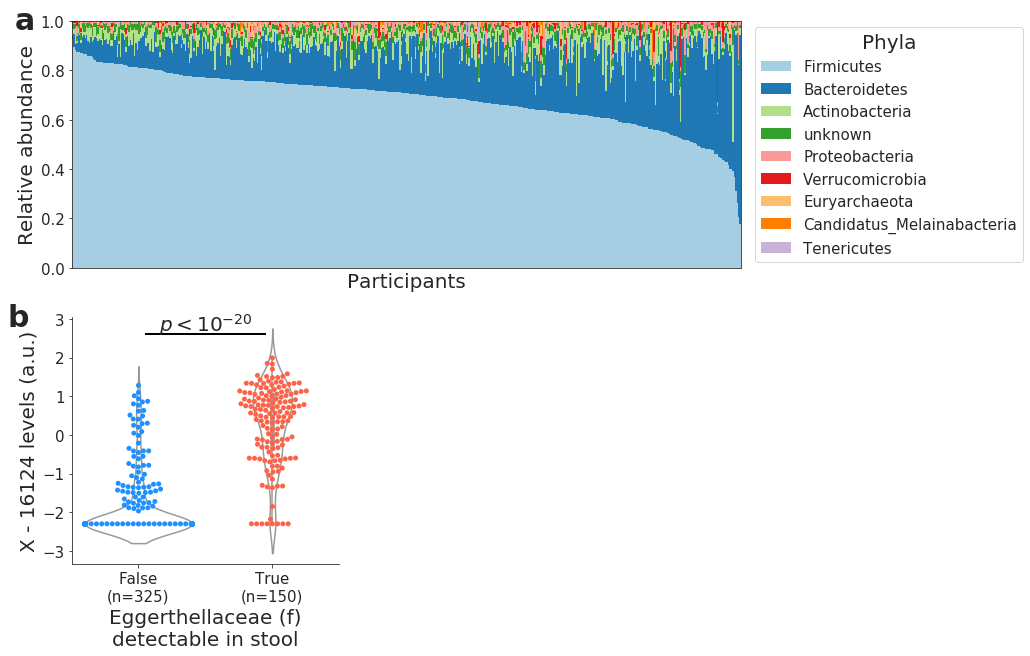

In [123]:
fig = plt.figure(figsize=(12, 10))
gs = gridspec.GridSpec(2, 2, wspace=0.5, hspace=0.2)


labels_fontsize = 20
tick_fontsize = 15

ax_phyla = fig.add_subplot(gs[0, :])
ax = ax_phyla

mb_full_phyla.iloc[:, :].plot(kind='bar', stacked=True, edgecolor=None, linewidth=0.01,
                               ax=ax, width=1, color=sns.color_palette('Paired', n_colors=mb_full_phyla.shape[1]))
ax.set_xticks([])
ax.set_ylim((0, 1))
ax.tick_params(labelsize=tick_fontsize)
ax.set_xlabel('Participants', fontsize=labels_fontsize)
ax.set_ylabel('Relative abundance', fontsize=labels_fontsize)
leg = ax.legend(ncol=1, loc='center left' , bbox_to_anchor=(1.01, 0.5),
                  fontsize=tick_fontsize, frameon=True, labelspacing=0.5, title='Phyla')
leg.get_title().set_fontsize(str(labels_fontsize))

ax_unknown = fig.add_subplot(gs[1, 0])
ax = ax_unknown
c = 'X - 16124'
k = mb_full_abs_shap.loc[c].sort_values().tail(1).head(1).index.values[0]
boxplot_df = pd.DataFrame(columns=['metabolite', 'bacteria'])
boxplot_df.bacteria = (mb_full.reindex(single_metabs.index, axis=0)[k] > mb_full.reindex(single_metabs.index, axis=0)[k].min()).astype(int)
boxplot_df.metabolite = single_metabs[c].copy()
sns.violinplot(x='bacteria', y='metabolite', data=boxplot_df, color='white', ax=ax)
sns.swarmplot(x='bacteria', y='metabolite', data=boxplot_df, palette=['dodgerblue', 'tomato'], ax=ax)
ax.tick_params(labelsize=tick_fontsize)
best_bac = _find_closest_ancestry(k)[0]
ax.set_xlabel(best_bac + '\ndetectable in stool', fontsize=labels_fontsize)
ax.set_ylabel(c + ' levels (a.u.)', fontsize=labels_fontsize)
ax.set_xticklabels(['False\n(n=%0.1d)'%((boxplot_df.bacteria == 0).sum()), 'True\n(n=%0.1d)'%((boxplot_df.bacteria == 1).sum())], fontsize=tick_fontsize)
# add_text_at_corner(ax, '$p<10^{-20}$', 'top left', fontsize=labelsize)
ax.text(0.5, 2.7,  '$p<10^{-20}$', ha='center', fontsize=labels_fontsize)
ax.hlines(y=2.6, xmin=0.05, xmax=0.95, linewidth=2, color='black')
# ax.text(0.5, 2.7,  '***', ha='center', fontsize=labelsize, color='red')
# ax.hlines(y=2.6, xmin=0.05, xmax=0.95, linewidth=2, color='red')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.tight_layout()
plt.text(-0.07, 1.0, 'a', ha='center', va='center', transform=ax_phyla.transAxes, fontsize=30, weight='bold')
plt.text(-0.2, 1.0, 'b', ha='center', va='center', transform=ax_unknown.transAxes, fontsize=30, weight='bold')

# plt.savefig(os.path.join(figure_dir, 'Extended_Data_Figure_8_small.png'), dpi=300, bbox_inches='tight')
# plt.savefig(os.path.join(figure_dir, 'Extended_Data_Figure_8.png'), dpi=1000, bbox_inches='tight')
# plt.savefig(os.path.join(figure_dir, 'Extended_Data_Figure_8.pdf'), dpi=500, bbox_inches='tight')

### fraction of X - 16124

In [482]:
min_val = boxplot_df.metabolite.min()
print ((boxplot_df[boxplot_df.bacteria == 0].metabolite > min_val).sum() / boxplot_df[boxplot_df.bacteria == 0].shape[0])
print ((boxplot_df[boxplot_df.bacteria == 1].metabolite > min_val).sum() / boxplot_df[boxplot_df.bacteria == 1].shape[0])
# boxplot_df

0.23384615384615384
0.9466666666666667


### get prediction R for paper

In [623]:
metabs1[metabs1.BIOCHEMICAL.str.contains('cotinine')]

,Group HMDB_ID,Sample HMDB_ID,BIOCHEMICAL,CAS,CHEMICAL_ID,CHEMSPIDER,KEGG,MASS,PATHWAY_SORTORDER,PLATFORM,PUBCHEM,RI,SUB_PATHWAY,SUPER_PATHWAY,COMMENT
COMP_ID,,,,,,,,,,,,,,,
43470,HMDB01204,NaN,3-hydroxycotinine glucuronide,132929-88-5,100004494,159230.0,NaN,367.11469,3599.0,LC/MS Neg,183115.0,1745.0,Tobacco Metabolite,Xenobiotics,3-hydroxycotinine glucuronide
553,HMDB01046,NaN,cotinine,486-56-6,848,746405.0,NaN,177.10224,3595.0,LC/MS Pos Early,854019.0,2213.0,Tobacco Metabolite,Xenobiotics,cotinine
38662,HMDB01411,NaN,cotinine N-oxide,36508-80-2,100002719,7991264.0,NaN,193.09716,3597.0,LC/MS Pos Early,9815514.0,1377.0,Tobacco Metabolite,Xenobiotics,cotinine N-oxide
38661,HMDB01390,NaN,hydroxycotinine,34834-67-8,100002717,8395266.0,NaN,193.09716,3596.0,LC/MS Pos Early,10219774.0,2030.0,Tobacco Metabolite,Xenobiotics,hydroxycotinine
57782,HMDB01297,NaN,norcotinine,17114-40-8,100002715,400.0,NaN,163.08659,3604.0,LC/MS Pos Early,413.0,2156.0,Tobacco Metabolite,Xenobiotics,norcotinine


In [624]:
mb_full_results.loc['848']

Size                            474.000000
Coefficient_of_determination     -0.016567
explained_variance_score         -0.016553
pearson_r                        -0.050345
pearson_p                         0.274004
spearman_r                       -0.034545
spearman_p                        0.453051
Name: 848, dtype: float64

In [621]:
metabs2look = {'100000453': 'paraxanthine', '849': 'caffeine', '100001178': 'CMPF', '100000870': 'saccharin', 
               '100006203': 'acesulfame', '100001417': 'phenylacetylglutamine' ,'100000467': '3-indoxyl sulfate', 
               '100006108': 'phenylacetylcarnitine', '100006191': 'p-cresol-glucuronide', '100004056':'N-methyltaurine'}
for k in metabs2look:
    print (metabs2look[k], 'MB:', '%0.3f'%mb_full_results.loc[k, 'pearson_r'], 'Diet:', '%0.3f'%diet_full_results.loc[k, 'pearson_r'])

phenylacetylcarnitine MB: 0.474 Diet: 0.107
acesulfame MB: 0.080 Diet: 0.472
CMPF MB: 0.102 Diet: 0.708
p-cresol-glucuronide MB: 0.639 Diet: 0.100


KeyError: '356'

### MB top predictors for top 50 metabs

In [20]:
idmax = mb_full_abs_shap.loc[mb_full_results.sort_values('pearson_r', ascending=False).head(50).index].idxmax(1).apply(lambda x: ' '.join(_find_closest_ancestry(x)))
max_shap = mb_full_abs_shap.loc[mb_full_results.sort_values('pearson_r', ascending=False).head(50).index].max(1)
r2 = mb_full_results.sort_values('pearson_r', ascending=False).head(50)['Coefficient_of_determination']
pd.concat((idmax, max_shap, r2), axis=1).rename(columns={0:'Best bacterial predictror', 1:'Mean absolute SHAP value', 'Coefficient_of_determination':'Prediction R2'}).to_csv('Supp_table5_top50_mb_shap.csv')

In [9]:
mb_full_abs_shap.loc[mb_full_results.sort_values('pearson_r', ascending=False).head(50).index].idxmax(1).value_counts()


k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__unknown|s__unknown|fSGB__1445|gSGB__3570|sSGB__4777                                                                          22
k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_sp_CAG_138|fSGB__2982|gSGB__9342|sSGB__14306                                                       5
k__unknown|p__unknown|c__unknown|o__unknown|f__unknown|g__unknown|s__unknown|fSGB__3062|gSGB__9747|sSGB__15356                                                                                              2
k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Blautia|s__Blautia_sp_CAG_237|fSGB__1449|gSGB__3589|sSGB__4810                                                               2
k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__unknown|s__unknown|fSGB__1215|gSGB__2975|sSGB__3957                                              

### distribution of phyla

In [453]:
pd.Series([s.split('|')[1] for s in mb_full_abs_shap.loc[mb_full_results.sort_values('pearson_r', ascending=False).head(115).index].idxmax(1)]).value_counts()

p__Firmicutes        102
p__unknown             7
p__Actinobacteria      5
p__Bacteroidetes       1
dtype: int64

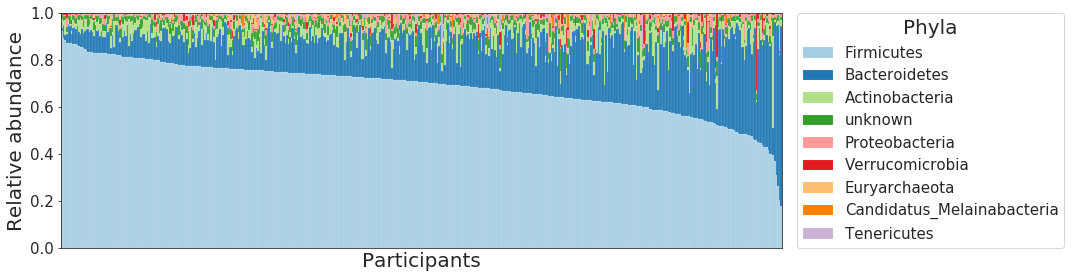

In [617]:
mb_full_phyla = mb_full.copy()
mb_full_phyla.columns = [s.split('|')[1].split('__')[1] for s in mb_full_phyla.columns]
mb_full_phyla = mb_full_phyla.T.reset_index().groupby('index').sum()

fig, ax = plt.subplots(1, 1, figsize=(15, 4))
labels_fontsize = 20
tick_fontsize = 15

mb_full_phyla = mb_full_phyla.apply(lambda x: x/x.sum(), axis=0)

mb_full_phyla = mb_full_phyla.loc[mb_full_phyla.mean(1).sort_values(ascending=False).index].T.sort_values('Firmicutes', ascending=False)

mb_full_phyla.iloc[:, :].plot(kind='bar', stacked=True, edgecolor='white', linewidth=0.1,
                               ax=ax, width=1, color=sns.color_palette('Paired', n_colors=mb_full_phyla.shape[1]))
ax.set_xticks([])
ax.set_ylim((0, 1))
ax.tick_params(labelsize=tick_fontsize)
ax.set_xlabel('Participants', fontsize=labels_fontsize)
ax.set_ylabel('Relative abundance', fontsize=labels_fontsize)
leg = ax.legend(ncol=1, loc='center left' , bbox_to_anchor=(1.01, 0.5),
                  fontsize=tick_fontsize, frameon=True, labelspacing=0.5, title='Phyla')
leg.get_title().set_fontsize(str(labels_fontsize))

fig.tight_layout()

plt.savefig(os.path.join(figure_dir, '4_supp_stacked_phyla_abundance_small.png'), dpi=200, bbox_inches='tight')
plt.savefig(os.path.join(figure_dir, '4_supp_stacked_phyla_abundance.png'), dpi=1200, bbox_inches='tight')

# Table of unknowns

In [236]:
# Updates regarding molecules (Mar 2019)


_molecule_name_update_mar2019 = {'X - 12230': '4-ethylcatechol sulfate',
                                 'X - 12329': '3-hydroxy-2-methylpyridine sulfate',
                                 'X - 12837': 'glucuronide of C19H28O4 (2)*',
                                 'X - 14662': 'glycoursodeoxycholate sulfate (1)',
                                 'X - 16654': 'deoxycholic acid (12 or 24)-sulfate*',
                                 'X - 17145': 'branched chain 14:0 dicarboxylic acid**',
                                 'X - 17469': 'lithocholic acid sulfate (1)',
                                 'X - 18249': '3,5-dichloro-2,6-dihydroxybenzoic acid',
                                 'X - 18914': '3-bromo-5-chloro-2,6-dihydroxybenzoic acid*',
                                 'X - 23649': '3-hydroxypyridine glucuronide'}
# comments regarding molecules (Mar 2019)
_molecule_comment_update_mar2019 = {'X - 11315': 'elucidation in progress; may be an amino acid derivative',
                                    'X - 11640': 'has been named for enterolactone sulfate as of earlier this month',
                                    'X - 11843': 'candidate structure is an aromatic amino acid related metabolite',
                                    'X - 11850': 'candidate structure is an aromatic amino acid related metabolite',
                                    'X - 12126': 'candidate structure is an aromatic amino acid related metabolite',
                                    'X - 12216': 'candidate structure is an aromatic amino acid related metabolite',
                                    'X - 12261': 'candidate structure is an aromatic amino acid related metabolite',
                                    'X - 12283': 'candidate structure is an aromatic amino acid related metabolite',
                                    'X - 12718': 'candidate structure is an aromatic amino acid related metabolite',
                                    'X - 12738': 'candidate structure is phenol-related',
                                    'X - 13835': 'candidate structure is an aromatic amino acid related metabolite',
                                    'X - 13844': 'candidate structure is a benzoic acid derivative',
                                    'X - 17185': 'candidate structure is phenol-related',
                                    'X - 17354': 'candidate structure is polyphenol related',
                                    'X - 21286': 'candidate structure is pyridine related',
                                    'X - 22509': 'candidate structure is polyphenol related',
                                    'X - 22520': 'fatty acid conjugate',
                                    'X - 23639': "high priority internally, but don't have a good guess right now",
                                    'X - 23655': 'candidate structure is pyridine related',
                                    'X - 24243': 'candidate structure is piperidine related',
                                    'X - 24410': 'candidate structure is piperidine related'}

In [282]:
identified_unknowns = mb_res.loc[_molecule_name_update_mar2019.keys()][['Coefficient_of_determination']]
identified_unknowns.index.names = ['CHEMICAL_ID']
identified_unknowns['name'] = identified_unknowns.index
identified_unknowns = identified_unknowns.reset_index().replace({'CHEMICAL_ID': _molecule_name_update_mar2019}).set_index('name')
identified_unknowns['Coefficient_of_determination'] = ['%0.2f'%f for f in identified_unknowns['Coefficient_of_determination']]
identified_unknowns.sort_values('Coefficient_of_determination', ascending=False).to_csv(os.path.join(figure_dir, 'identified_unknowns.csv'))

candidates_unknowns = mb_res.loc[_molecule_comment_update_mar2019.keys()][['Coefficient_of_determination']]
candidates_unknowns.index.names = ['CHEMICAL_ID']
candidates_unknowns['name'] = candidates_unknowns.index
candidates_unknowns = candidates_unknowns.reset_index().replace({'CHEMICAL_ID': _molecule_comment_update_mar2019}).set_index('name')
candidates_unknowns['Coefficient_of_determination'] = ['%0.2f'%f for f in candidates_unknowns['Coefficient_of_determination']]
candidates_unknowns.sort_values('Coefficient_of_determination', ascending=False).to_csv(os.path.join(figure_dir, 'candidates_unknowns.csv'))

In [155]:
mb_shap = pd.read_csv('/net/mraid08/export/jafar/Microbiome/Analyses/Noamba/Metabolon/technical_noise/RSCV/LightGBM/metabolomics_MB_daphna_LONG5_S/abs_signed_shap.csv', index_col=0)
updated_metabs1 = pd.read_csv(os.path.join(paper_dir, 'dataframes', 'updated_metabs1.csv'), index_col=0)

In [173]:
tryp_metabs = updated_metabs1[updated_metabs1.SUB_PATHWAY.fillna('').str.contains('Tryptophan ')]

tryp_metabs = tryp_metabs.loc[mb_full_results.loc[tryp_metabs.index]['Coefficient_of_determination']>0.02]

get_nlargest_cols(mb_shap.loc[tryp_metabs.index], n=5, col_name='Bacteria', val_name='SHAP value').merge(updated_metabs1[['BIOCHEMICAL', 'SUB_PATHWAY']], on='CHEMICAL_ID').to_csv('~/tryptophan_subpathway_bacterial_predictors.csv')

In [174]:
tryp_metabs

,COMP_ID,Group HMDB_ID,Sample HMDB_ID,BIOCHEMICAL,CAS,CHEMSPIDER,KEGG,MASS,PATHWAY_SORTORDER,PLATFORM,PUBCHEM,RI,SUB_PATHWAY,SUPER_PATHWAY,COMMENT
CHEMICAL_ID,,,,,,,,,,,,,,,
100000467,27672,HMDB00682,NaN,3-indoxyl sulfate,2642-37-7,9840.0,NaN,212.00230,241.0,LC/MS Neg,10258.0,2222.2,Tryptophan Metabolism,Amino Acid,3-indoxyl sulfate
1258,4970,HMDB01123,NaN,anthranilate,118-92-3,222.0,C00108,138.05496,215.0,LC/MS Pos Early,227.0,2606.0,Tryptophan Metabolism,Amino Acid,anthranilate
100001034,27513,HMDB00197,NaN,indoleacetate,6505-45-9,780.0,C00954,174.05605,229.0,LC/MS Neg,802.0,2200.0,Tryptophan Metabolism,Amino Acid,indoleacetate
100001083,32405,HMDB02302,NaN,indolepropionate,830-96-6,3613.0,NaN,188.07170,231.0,LC/MS Neg,3744.0,2795.0,Tryptophan Metabolism,Amino Acid,indolepropionate
100001743,37097,HMDB61115,NaN,tryptophan betaine,20671-76-5,390633.0,C09213,247.14411,206.0,LC/MS Pos Early,442106.0,2673.0,Tryptophan Metabolism,Amino Acid,tryptophan betaine
